In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
%matplotlib inline

# Load data

Load the data and display the first rows

In [7]:
in_file = 'power_data.csv'
df = pd.read_csv(in_file)
df.head()  # Only shows the first 5 rows rather than all rows

,Unnamed: 0,Datetime,Power_MWH
0,0,2010-01-01 00:00:00,31647.0
1,1,2010-12-31 01:00:00,29634.0
2,2,2010-12-31 02:00:00,28614.0
3,3,2010-12-31 03:00:00,28146.0
4,4,2010-12-31 04:00:00,28051.0


# Data Analysis and Preprocessing

Remove extra column

Move to datetime format

Sort ascending

Check if there are any NaN, missing or duplicate value


In [8]:
df=df.drop('Unnamed: 0', axis=1) #remove the extra column

df['Datetime'] = pd.to_datetime(df.Datetime, infer_datetime_format = True) # move to date-time format

df = df.set_index('Datetime')

df = df.sort_index() #sort ascending


print(f'# NaN values: {df.isnull().sum().sum()}\n') # Count NaN values
desired_range=pd.date_range(start=df.index.min(), end=df.index.max(),freq='H')
missing_idx=desired_range.difference(df.index)
duplicate_idx = df[df.index.duplicated(keep=False)]
print(f'Missing indices are:\n {missing_idx}\n')
print(f'Duplicate indices are:\n {duplicate_idx}')

df

# NaN values: 0

Missing indices are:
 DatetimeIndex(['2010-03-14 03:00:00', '2010-11-07 02:00:00',
               '2010-12-10 00:00:00', '2011-03-13 03:00:00',
               '2011-11-06 02:00:00', '2012-03-11 03:00:00',
               '2012-11-04 02:00:00', '2013-03-10 03:00:00',
               '2013-11-03 02:00:00', '2014-03-09 03:00:00',
               '2015-03-08 03:00:00', '2016-03-13 03:00:00',
               '2017-03-12 03:00:00', '2018-03-11 03:00:00'],
              dtype='datetime64[ns]', freq=None)

Duplicate indices are:
                      Power_MWH
Datetime                      
2014-11-02 02:00:00    22935.0
2014-11-02 02:00:00    23755.0
2015-11-01 02:00:00    21567.0
2015-11-01 02:00:00    21171.0
2016-11-06 02:00:00    21692.0
2016-11-06 02:00:00    20795.0
2017-11-05 02:00:00    20666.0
2017-11-05 02:00:00    21236.0


,Power_MWH
Datetime,
2010-01-01 00:00:00,31647.0
2010-01-01 01:00:00,30075.0
2010-01-01 02:00:00,28907.0
2010-01-01 03:00:00,27906.0
2010-01-01 04:00:00,27373.0
...,...
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0


# Note

Average the duplicate values

Do not fill the missing values. Those days with one missing hour (which are only 14 days) can be counted as outliers which can be always present in the training or testing dataset. 

Sum the hours for each day since a total consumption for a day is requested.

Remove the last row since only one hour is available for the whole day

In [9]:
df=df.groupby(df.index).mean() # duplicate values are averaged

df=df.resample('D').sum() # sum all hours in a day

df=df.loc[:'2018-08-02'] # dropping the last row (2018-08-03)

# Split data to train and test

Test data should be separated before any observations for feature selection to prevent potential bias. I will use ~20% of data for testing.

Note that final feature extraction will be performed on both datasets but only train_data will be used for observations and feature selection.

In [10]:
df_train = df[:int(0.8*len(df))].copy()
df_test = df[int(0.8*len(df)):].copy()

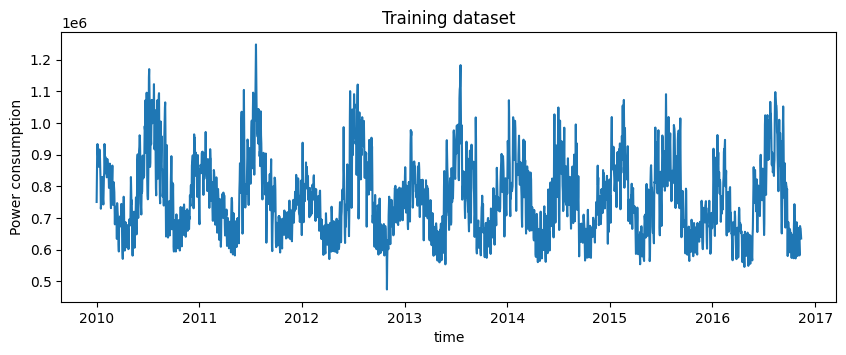

In [11]:
# plot the training dataset
fig, ax = plt.subplots(figsize=(10, 3.5))
ax.plot(df_train['Power_MWH'])
plt.xlabel('time')
plt.ylabel('Power consumption')
plt.title('Training dataset')
plt.show()

There are some noises/outliers present. However, manipulating those indicates that our future test sets would be without any noise/outliers. It's best to keep them. 

Possible ways to remove the noise/outliers if needed:

•	Removing noise by moving the dataset from time domain to the frequency domain. Then filter out the undesired frequencies. This can be done by using a Fourier transform.

•	Removing outliers that are n=3 standard deviations above or below the mean or out of the interquartile range.


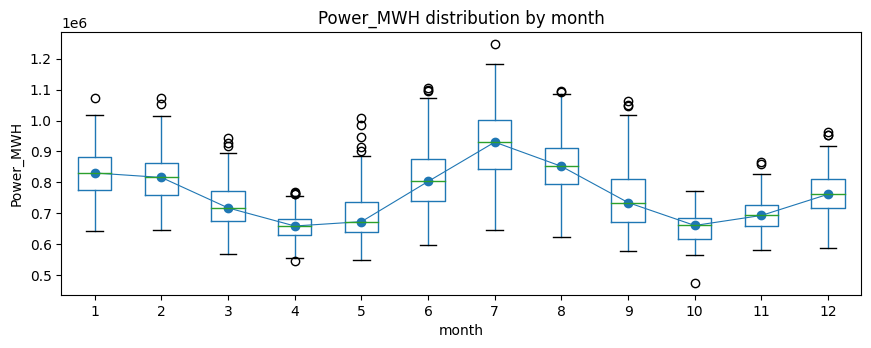

In [12]:
fig, ax = plt.subplots(figsize=(10, 3.5))
df_train['month'] =df_train.index.month
df_train.boxplot(column='Power_MWH', by='month', ax=ax,)
df_train.groupby('month')['Power_MWH'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Power_MWH')
ax.set_title('Power_MWH distribution by month')
fig.suptitle('');
df_train=df_train.drop('month', axis=1) #remove the unnecessary feature

This plot shows that month can be a good feature to work with, since there are differences in the median between various months.

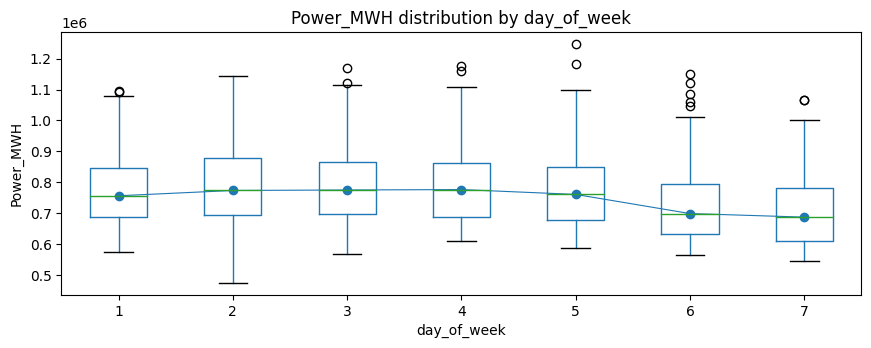

In [13]:
fig, ax = plt.subplots(figsize=(10, 3.5))
df_train['day_of_week'] = df_train.index.day_of_week +1
df_train.boxplot(column='Power_MWH', by='day_of_week', ax=ax,)
df_train.groupby('day_of_week')['Power_MWH'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Power_MWH')
ax.set_title('Power_MWH distribution by day_of_week')
fig.suptitle('');
df_train=df_train.drop('day_of_week', axis=1) 

lower demand values during the weekend. So a feature called "is_weekend" should be present.

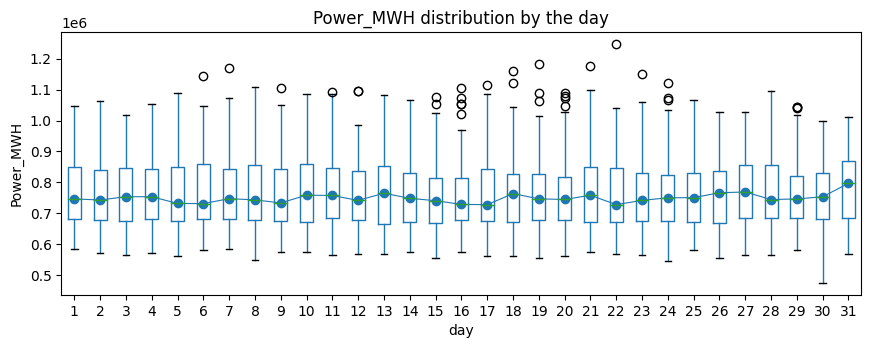

In [14]:
fig, ax = plt.subplots(figsize=(10, 3.5))
df_train['day'] = df_train.index.day
df_train.boxplot(column='Power_MWH', by='day', ax=ax,)
df_train.groupby('day')['Power_MWH'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Power_MWH')
ax.set_title('Power_MWH distribution by the day')
fig.suptitle('');
df_train=df_train.drop('day', axis=1) 

We cannot see a considerable variation between days of the month.

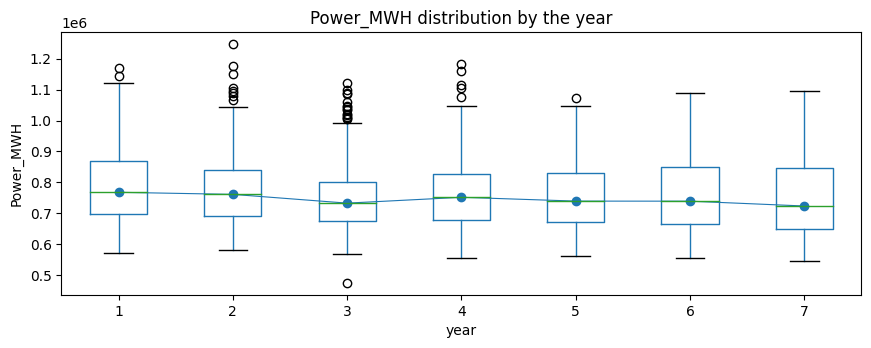

In [15]:
fig, ax = plt.subplots(figsize=(10, 3.5))
df_train['year'] = df_train.index.year-2009
df_train.boxplot(column='Power_MWH', by='year', ax=ax,)
df_train.groupby('year')['Power_MWH'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Power_MWH')
ax.set_title('Power_MWH distribution by the year')
fig.suptitle('');
df_train=df_train.drop('year', axis=1) 

We cannot see a considerable variation between different years.

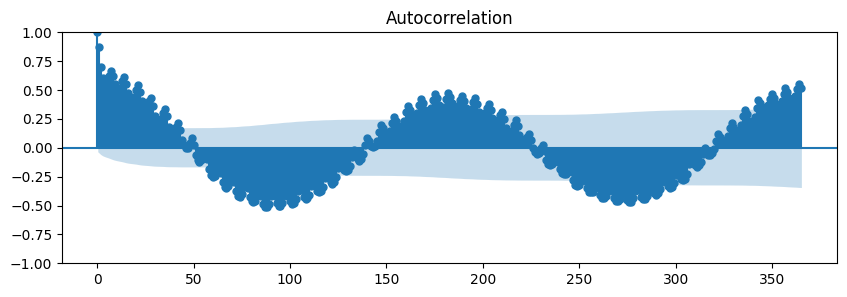

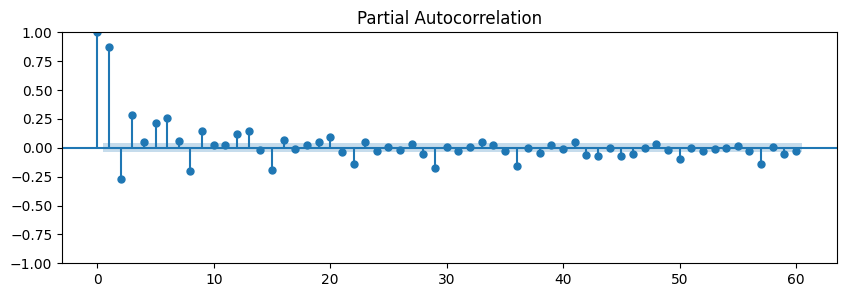

In [18]:
# Autocorrelation plot for 4 days
# %matplotlib Widget
fig, ax = plt.subplots(figsize=(10, 3))
plot_acf(df_train['Power_MWH'], ax=ax, lags=365)
plt.show()
# Partial Autocorrelation plot for 4 days
fig, ax = plt.subplots(figsize=(10, 3))
plot_pacf(df_train['Power_MWH'], ax=ax, lags=60,method='ywm')
plt.show()

There is a correlation between the current value and the values of 1 and 2 previous days. Also they may be an indirect correlation with 90,180,270 and 365 days before.

# Extracting possible features

In [12]:
def feature_ext(df_temp):
    df_temp['month'] =df_temp.index.month
    df_temp['is_weekend'] = np.where(df_temp.index.day_name().isin(['Sunday','Saturday']),1,0)
    
    # lag/window features
    

    df_temp['5D_median']=df_temp['Power_MWH'].shift(1).rolling('5D').median()
    
    df_temp['1week_median']=df_temp['Power_MWH'].shift(1).rolling('7D').median()



    df_temp['5D_intqr']=(df_temp['Power_MWH'].shift(1).rolling('5D').quantile(0.75)-
                       df_temp['Power_MWH'].shift(1).rolling('5D').quantile(0.25))
    df_temp['1week_intqr']=(df_temp['Power_MWH'].shift(1).rolling('7D').quantile(0.75)-
                          df_temp['Power_MWH'].shift(1).rolling('7D').quantile(0.25))

                           
    df_temp['1D_before']=df_temp['Power_MWH'].shift(1)
    df_temp['2D_before']=df_temp['Power_MWH'].shift(2)

    df_temp['7D_before']=df_temp['Power_MWH'].shift(7)
    df_temp['90D_before']=df_temp['Power_MWH'].shift(90)
    df_temp['180D_before']=df_temp['Power_MWH'].shift(180)
    df_temp['270D_before']=df_temp['Power_MWH'].shift(270)
    df_temp['1year_before']=df_temp['Power_MWH'].shift(365)
    

    
    
    
    df_temp = df_temp.interpolate(method = 'backfill', limit_direction = 'backward') # fill missing values with later one

    return df_temp

# pass the training dataset
df=feature_ext(df)
power_df=df['Power_MWH']
df_raw = df.drop('Power_MWH', axis=1) # so this value won't be standardized
normalized_df=(df_raw-df_raw.mean())/df_raw.std()
normalized_df['Power_MWH']=power_df
df_train = normalized_df[:int(0.8*len(normalized_df))].copy()
df_test = normalized_df[int(0.8*len(normalized_df)):].copy()

Check the correlation between features and target.

Note: Since the power data was not following a normal distribution (according to the Shapiro-Wilk test), I also tried features using meadian and interquartile range. However, avg & std features showed higher correlation and are preferred here.

In [13]:
# import seaborn as sns
# sns.heatmap(df_train.corr(),cmap="YlGnBu")
correlations=df_train.corr()['Power_MWH']
abs(correlations).sort_values(ascending=False)

Power_MWH       1.000000
1D_before       0.873378
1week_median    0.738916
5D_median       0.715017
2D_before       0.699422
7D_before       0.668656
1year_before    0.557481
270D_before     0.500220
90D_before      0.430953
180D_before     0.371863
1week_intqr     0.332237
5D_intqr        0.295158
is_weekend      0.283712
month           0.119235
Name: Power_MWH, dtype: float64

In [14]:
# df.plot.hist(bins=10, alpha=0.5)
# from scipy.stats import shapiro
# shapiro(df)

# Baseline model design

There are few choices for a baseline model. The strategy below will take the value of the day before ("1D_before" feature) since it was mostly correlated with the power consumption value.

Baseline training RMSE:58961.27611577921
Baseline training r2 score:0.7468165119743841

Baseline testing RMSE:59946.54256269779
Baseline testing r2 score:0.6823332467882031


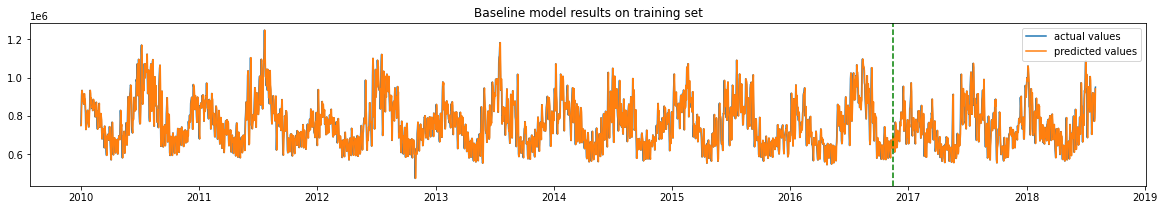

In [15]:
from sklearn.metrics import mean_squared_error, r2_score

# training set
predictions_train=df_train['Power_MWH'].shift(1)
predictions_train = predictions_train.interpolate(method = 'backfill', limit_direction = 'backward')
# testing set
predictions_test=df_test['Power_MWH'].shift(1)
predictions_test = predictions_test.interpolate(method = 'backfill', limit_direction = 'backward')    

actual_train = df_train['Power_MWH']
print(f'Baseline training RMSE:{np.sqrt(mean_squared_error(actual_train,predictions_train))}')
print(f'Baseline training r2 score:{r2_score(actual_train,predictions_train)}\n')

actual_test = df_test['Power_MWH']
print(f'Baseline testing RMSE:{np.sqrt(mean_squared_error(actual_test,predictions_test))}')
print(f'Baseline testing r2 score:{r2_score(actual_test,predictions_test)}')

fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(df.index,normalized_df['Power_MWH'],label='actual values')
ax.plot(df.index,[*predictions_train, *predictions_test],label='predicted values')
ax.axvline(x=df_test.index[0], linestyle='--',color='green')
plt.legend(loc='best')
plt.title('Baseline model results on training set')
plt.show()

The green dashed line is presenting the start of test sets.

Other baselines with taking the average/median of n previous days were also tested but as expected, above model had the best performance among others, due to the higher correlation of "1day" feature to the power consumption.

# Parametric model design 1: linear regression

Training the model using "one step ahead cross validation" with linear regression

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
tscv = TimeSeriesSplit(n_splits=6)
X = df_train.drop('Power_MWH', axis=1) 
y = df_train[['Power_MWH']]
model = LinearRegression()
counter=-1
for train_index, cv_index in tscv.split(X):
    counter += 1
    X_train, X_cv = X.loc[X.index[train_index]], X.loc[X.index[cv_index]]
    y_train, y_cv = y.loc[y.index[train_index]], y.loc[y.index[cv_index]]
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train).reshape(-1, 1)
    y_pred_cv = model.predict(X_cv).reshape(-1, 1)
    print(f'Training year: 2010 - {2010+counter}, validation year: {2010+counter+1}')
    print(f'RMSE training:{np.sqrt(mean_squared_error(y_train,y_pred_train))}')
    print(f'RMSE validation:{np.sqrt(mean_squared_error(y_cv,y_pred_cv))}\n')

Training year: 2010 - 2010, validation year: 2011
RMSE training:50109.16816272272
RMSE validation:45512.402798135365

Training year: 2010 - 2011, validation year: 2012
RMSE training:46963.69790372447
RMSE validation:47448.829420916205

Training year: 2010 - 2012, validation year: 2013
RMSE training:46977.473036347634
RMSE validation:46711.366428606525

Training year: 2010 - 2013, validation year: 2014
RMSE training:46866.66755211377
RMSE validation:49175.202423369585

Training year: 2010 - 2014, validation year: 2015
RMSE training:47267.09367609181
RMSE validation:48494.815007721205

Training year: 2010 - 2015, validation year: 2016
RMSE training:47431.31915975525
RMSE validation:45708.04423670144



Training the model on the full training set

RMSE training:47165.15081560791
r2 score training:0.8379891559457

RMSE testing set:49506.57105587309
r2 score testing set:0.7833447694891291


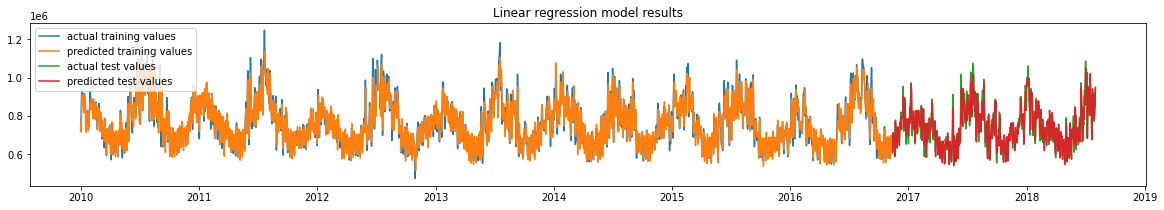

In [17]:
from sklearn.linear_model import LinearRegression

X = df_train.drop('Power_MWH', axis=1) 


y = df_train[['Power_MWH']]

model_LR = LinearRegression().fit(X, y)
y_predict = model_LR.predict(X).reshape(-1, 1)


print(f'RMSE training:{np.sqrt(mean_squared_error(y,y_predict))}')
print(f'r2 score training:{r2_score(y,y_predict)}\n')

X1 = df_test.drop('Power_MWH', axis=1)
y1 = df_test[['Power_MWH']]
y1_predict = model.predict(X1).reshape(-1, 1)

print(f'RMSE testing set:{np.sqrt(mean_squared_error(y1,y1_predict))}')
print(f'r2 score testing set:{r2_score(y1,y1_predict)}')

fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(df_train.index,y,label='actual training values')
ax.plot(df_train.index,y_predict,label='predicted training values')
plt.title('Linear regression model results')
ax.plot(df_test.index,y1,label='actual test values')
ax.plot(df_test.index,y1_predict,label='predicted test values')
plt.legend(loc=2)
plt.show()

Limitations: This model requires manual feature extraction. There may be other useful features that are not included in this analysis and so some information may be lost. This is the problem of conventional machine learning algorithms. 

Note: for using models that require feature extraction, we need to assume that our features are known, for both training and testing sets. Since we are using lag/window features which are dependent on the previous days' targets, we need to assume that for each test data, we have the actual target of the previous days. Using predicted targets as features for the next prediction will increase the error day by day and will result in a failure. 

# Parametric model design 2: a simple neural network 

Training a model using neural networks with one relu activation

In [18]:
import torch
from torch import nn, optim
import torch.nn.functional as F
features = df_train.drop('Power_MWH', axis=1) 
features=torch.tensor(features.values).float()
targets=df_train['Power_MWH']
targets=torch.tensor(targets.values).float()
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(13, 32)
        self.fc2 = nn.Linear(32, 1)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = self.fc2(F.relu(self.fc1(x)))
        
        return x

    
model_NN = Regressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model_NN.parameters(), lr=0.01)
epochs = 70
for e in range(epochs):
    running_loss = 0
    counter=0
    for var, labels in zip(features, targets):
        counter+=1
        log_ps = model_NN(var)
        loss = criterion(log_ps, labels.view(1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        if e%10==0:
            print(f"Training loss: {np.sqrt(running_loss/counter)}")

Training loss: 758250.8638506257
Training loss: 209230.95653710878
Training loss: 50686.92786770821
Training loss: 47478.23588424504
Training loss: 47265.039169563985
Training loss: 47216.95328004202
Training loss: 47191.059384181965


RMSE training:47221.7890625
r2 score training:0.8375998438673669

RMSE test:50224.947425827755
r2 score test:0.7770115002081155


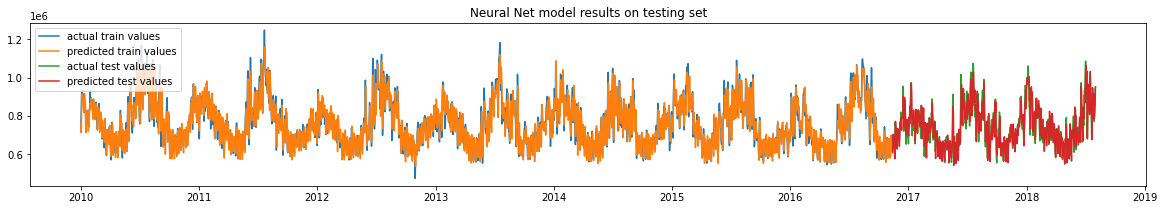

In [19]:
# testing the model with the training and testing sets

y_train=model_NN(features)

print(f'RMSE training:{np.sqrt(mean_squared_error(targets,y_train.detach().numpy()))}')
print(f'r2 score training:{r2_score(targets,y_train.detach().numpy())}\n')

features_test = torch.tensor(df_test.drop('Power_MWH', axis=1).values).float()
targets_test=df_test['Power_MWH']
y_test=model_NN(features_test)

print(f'RMSE test:{np.sqrt(mean_squared_error(targets_test,y_test.detach().numpy()))}')
print(f'r2 score test:{r2_score(targets_test,y_test.detach().numpy())}')

fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(df_train.index,targets,label='actual train values')
ax.plot(df_train.index,y_train.detach().numpy(),label='predicted train values')
ax.plot(df_test.index,targets_test,label='actual test values')
ax.plot(df_test.index,y_test.detach().numpy(),label='predicted test values')
plt.legend(loc=2)
plt.title('Neural Net model results on testing set')
plt.show()


It can be seen that test results of NN model are similar to the linear regression model. Both have small improvement in comparison to the baseline. To get better resutls, high-level time-dependent features are needed.

# Discussing a more advanced model: LSTM networks

In the advanced deep learning models, feature extraction/engineering is done automatically through the deep layers, starting from low-level features and moving towards more complex ones. This eliminates the need for manually selecting features and losing valuable information.

Moreover, using recurrent deep-learned models allow us to capture the time dependencies between different days and use one prediction to provide feedback for calculating the next prediction in the batch. In recurrent networks, outputs of hidden layers will serve as an additional input (known as memory) to the network during the next training step.

Long short-term memory (LSTM) networks are therefore the ideal candidate for predicting time-dependent labels. They are specialized type of recurrent neural networks (RNN) that learn to predict future trends from sequences of variable lengths and eliminate the vanishing gradient problem that may be present by using a simple RNN. An LSTM network with 2 or 3 hidden layers should provide adequate prediction performance in this problem.